# Setup

In [ ]:
!pip install copulas
!pip install openturns

In [ ]:
import copulas
import numpy as np
import matplotlib.pyplot as plt
import math
import mpmath
import openturns as ot
import pandas as pd
import random
import scipy
import seaborn as sns
import statsmodels
import sklearn
import time

from copulas import bivariate, multivariate
from itertools import combinations, combinations_with_replacement, permutations
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Gaussian random sampler


In [ ]:
# Set up some clusters
mean_1 = [0,0,0,0]
cov_1 = [[3,0,0,0],[0,3,0,0],[0,0,3,0],[0,0,0,3]]
mean_2 = [5,5,5,5]
cov_2 = [[3,0,0,0],[0,3,0,0],[0,0,3,0],[0,0,0,3]]
mean_3 = [7,7,7,7]
cov_3 = [[3,0,0,0],[0,3,0,0],[0,0,3,0],[0,0,0,3]]
# Random sampler
# Means, covariances and cluster probabilities must be correctly ordered
def random_sampler_gaussian(means,
                            covariances,
                            clusters,
                            cluster_probability,
                            samples,
                            ):
  # Sense checks
  if len(means) != len(covariances) or  len(covariances) != clusters:
    raise ValueError('Dimensions of parameters do not match.')
  if np.sum(cluster_probability) != 1:
    raise ValueError('Cluster probabilities do not sum to 1.')
  
  # Create  list that will hold the observations
  random_samples = []

  # Loop through based on the number of samples
  for sample in range(samples):
    # Randomly generate number which will decide cluster
    random_number = np.random.random()
     
    # Store current total probability
    total_prob = 0

    # Go through each possible cluster
    for counter, cluster_prob in enumerate(cluster_probability):
      # Update the overall probability
      total_prob += cluster_prob

      #Check if assigned to this cluster
      if random_number <= total_prob:

        # Generate sample
        current_sample = np.random.multivariate_normal(mean=means[counter],
                                                       cov=covariances[counter])

        # Add the current samples cluster
        current_sample = np.append(current_sample,
                                   counter)
        
        # Add the sample to the list
        random_samples.append(current_sample)
        
        # Move to next sample
        break

  # Return the samples
  return np.asarray(random_samples)

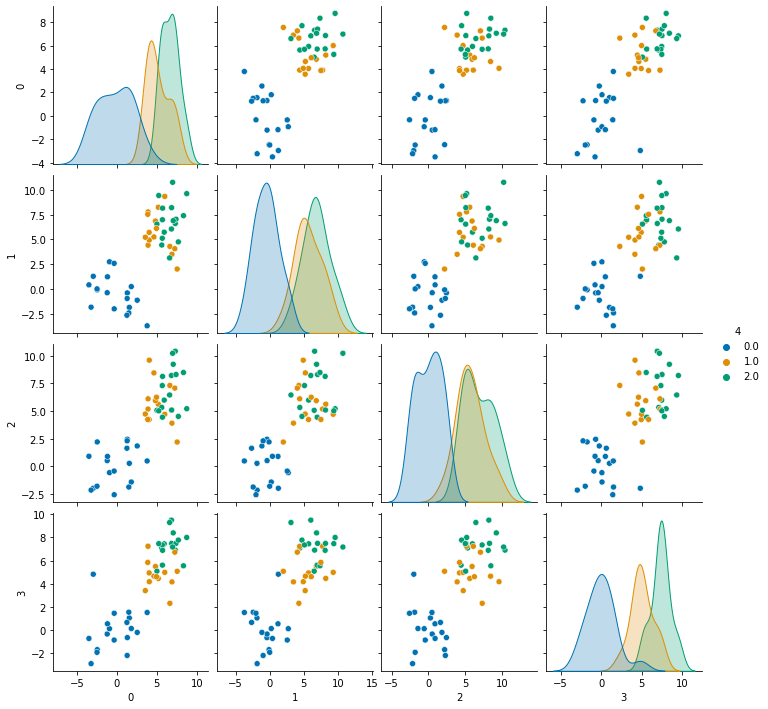

In [ ]:
# Generate some samples
gaussian_samples = random_sampler_gaussian(means=[mean_1,mean_2,mean_3],
                                           covariances=[cov_1,cov_2,cov_3],
                                           clusters=3,
                                           cluster_probability=[0.4,0.3,0.3],
                                           samples=50,
                                           )
# Convert data to pandas to be compatible with seaborn
sample_dataframe = pd.DataFrame(gaussian_samples)

# Plot the samples
sns.pairplot(sample_dataframe,
             hue=4,
             palette='colorblind')

# Performance metrics

In [ ]:
### Unfortunately, the way the below functions are initialised means that the ordering of cluster labels
### will always be random. As such, the scikit-learn accuracy function is unreliable. The function below
### will iterate through each ordering of clusters and then will return the highest accuracy. This function 
### requires that the true labels begin at 0 and then consists of the natural numbers.
### Additionally, it will calculate the AIC and BIC given the model log-likelihood and the
### number of free parameters.

# Write a function that will calculate accuracy and AIC/ BIC.
def performance_metrics(labels_true,
                        labels_predicted,
                        log_likelihood,
                        parameters):
  # Store the number of clusters and observations
  clusters = len(np.unique(labels_true))
  observations = len(labels_true)

  # Make sure labels are stored as an interger
  labels_true = np.int_(labels_true)
  labels_predicted = np.int_(labels_predicted)

  # Store the best accuracy
  accuracy = 0

  #Iterate through each permutation of the clusters
  for permutation in permutations(range(clusters)):
    # Store correct labels
    correct_labels = 0
    # Iterate through each true label
    for counter, true_label in enumerate(labels_true):
      # Check if the true label is equal to the predicted label, for this permutation
      if true_label == permutation[labels_predicted[counter]]:
        correct_labels += 1
    
    # Check if accuracy has improved, and if so update the best accuracy
    current_accuracy = correct_labels/observations
    if current_accuracy >= accuracy:
      accuracy = current_accuracy
  
  # Calculate AIC and BIC
  aic = 2*parameters - 2*log_likelihood
  bic = parameters*math.log(observations)-2*log_likelihood

  # Return the performance metrics
  return aic, bic, accuracy

# GMM full likelihood EM algorithm

## Setup helper functions

In [ ]:
# First, write function that finds MLE estimate of Gaussian parameters
def gaussian_mle(data):
  # Calculate mean
  mu = np.mean(data,
               axis=0)
  
  # Calculate variance
  var = np.cov(data,
               rowvar=False)

  # Return the mean and variance
  return mu, var

# Then write function that will calculate overall density of observation in GMM
def gmm_observation_density(observation,
                            cluster_priors,
                            means,
                            variances,
                            ):
  # Store total density
  total_density = 0

  # Iterate through each cluster
  for cluster in range(len(cluster_priors)):
    total_density += cluster_priors[cluster]*multivariate_normal.pdf(observation,
                                                                     means[cluster],
                                                                     variances[cluster],
                                                                     )

  # Return the total density
  return total_density

# Then write function that will calculate overall log-likelihood for a dataset
def gmm_log_likelihood(data,
                       cluster_priors,
                       means,
                       variances,
                       ):
  # Initialise model likelihood
  model_log_likelihood = 0

  # Store observations
  observations = data.shape[0]

  # Iterate through the observations in the data
  for observation in range(observations):
    model_log_likelihood += math.log(gmm_observation_density(data[observation],
                                                             cluster_priors,
                                                             means,
                                                             variances,
                                                             ))
    
  # Return model log-likelihood
  return model_log_likelihood

## EM algorithm

In [ ]:
# GMM EM algorithm, using full likelihood
def gmm_full_likelihood(data,
                        clusters,
                        max_iter=10000,
                        tol=1e-08):
  # Time the algorithm
  start_time = time.time()

  # Check data type is numpy array
  if type(data) != np.ndarray:
    raise ValueError('Data must be as a numpy array!')

  # Initialise parameter vectors
  observations = data.shape[0]
  features = data.shape[1]
  z = np.zeros((observations,clusters))
  t = np.zeros(clusters)
  mu = []
  cov = []

  # Use K-means to get initial cluster assignments
  kmeans = KMeans(n_clusters=clusters)
  kmeans.fit(data)
  kmeans_labels = np.asarray(kmeans.labels_)
  labels = kmeans_labels.flatten()

  # Use initial clusters to get initial parameter estimates for each cluster
  # Iterate through each cluster
  for cluster in range(clusters):
    #  Store where the data is from this cluster
    cluster_indices = np.where(labels==cluster)
    
    # Store the observations from this cluster
    cluster_data = data[cluster_indices[0]]
    # Add each cluster observation to the cluster data
    for index in cluster_indices[1:]:
      cluster_data = np.vstack((cluster_data,data[index]))
    
    # Calculate mean and variance of this cluster
    cluster_mean, cluster_covariance = gaussian_mle(cluster_data)

    # Store the cluster mean and covariance
    mu.append(cluster_mean)
    cov.append(cluster_covariance)

  # Set each t equal to the percentage of observations in each cluster by K-means
  for cluster in range(clusters):
    t[cluster] = len(np.where(labels==cluster)[0])/observations

  # Store the current overall-log likelihood of the data
  current_model_log_likelihood = -np.inf
  # Run max number of iterations
  for epoch in range(max_iter):
    # E-step: set each z
    # Iterate through each observation
    for observation in range(observations):
      # Iterate  through each cluster
      for cluster in range(clusters):
        # Calculate cluster probability
         cluster_prob = t[cluster]*multivariate_normal.pdf(data[observation],
                                                           mu[cluster],
                                                           cov[cluster])

         # Calculate total density of this observation
         total_density_i = gmm_observation_density(observation=data[observation],
                                                   cluster_priors=t,
                                                   means=mu,
                                                   variances=cov)

         # Calculate z, for this observation, this cluster
         z_ik = cluster_prob/total_density_i

         # Update the z matrix with z_ik
         z[observation,cluster]=z_ik

    # M-step 1: Calculate each t as an average of the z's
    for cluster in range(clusters):
      t[cluster] = np.mean(z[:,cluster])

    # M-step 2: Use closed form solution to update means and covariances for each cluster
    # Iterate through each cluster
    for cluster in range(clusters):
      # Update mean using closed form solution
      mu[cluster] = np.average(data,
                               axis=0,
                               weights=z[:,cluster],
                               )

      # Calculate covariance matrix using closed form solution
      cov[cluster] =  np.cov(data,
                             rowvar=False,
                             aweights=z[:,cluster],
                             )

    # Calculate current epoch model log-likelihood
    epoch_log_likelihood = gmm_log_likelihood(data,
                                              t,
                                              mu,
                                              cov)

    # Check if model has converged
    if epoch_log_likelihood - current_model_log_likelihood <= tol:
      # Calculate elapsed time
      elapsed_time = time.time()-start_time
      print(f'Algorithm stopped early after {epoch} iterations and {elapsed_time} seconds elapsed.')
      break
    # Update previous iteration log_likelihood
    current_model_log_likelihood = epoch_log_likelihood

    # Recover the labels of each observation
    # Store labels
    labels = []

    #Iterate through each observation
    for observation in range(observations):
      # Find the cluster with the highest likelihood
      current_label = np.argmax(z[observation])

      # Add the current label to the list
      labels.append(current_label)
  
  # Calculate and store the free parameters
  free_parameters = (observations+1)*(clusters-1) + clusters*(features*2+features*(features-1)/2)

  # Return the model likelihood, free parameters and the observation labels
  return  current_model_log_likelihood,labels, free_parameters

## Seeing if it works/ playing around

In [ ]:
full_model = gmm_full_likelihood(data=gaussian_samples[:,0:4],clusters=3)
performance_metrics(gaussian_samples[:,4], full_model[1],full_model[0],20)

Algorithm stopped early after 4 iterations and 0.6571722030639648 seconds elapsed.


(850.6468480299562, 888.8873081385192, 0.8)

# GMM pairwise likelihood EM algorithm

## Setup helper functions

In [ ]:
# First, write function that will calculate the pairwise log-likelihood for a given cluster
def cluster_pairwise_likelihood (mean,
                                 data,
                                 cov,
                                 z):
  # Store the cluster likelihood and count observations and features
  log_likelihood = 0
  observations = data.shape[0]
  features = data.shape[1]

  # Check dimensions are ok
  if observations != z.shape[0] or features != z.shape[1]:
    raise ValueError('Dimensions of data and parameters do not match!')

  # Iterate through each observation
  for observation in range(observations):
    # Iterate through each pairwise combination of features:
    for combination in combinations(range(features),2):
      # Store current features
      f1 = combination[0]
      f2 = combination[1]
      
      # Isolate current pair and observation z
      z_current = z[observation,f1,f2]

      # Store current mean and cov
      mu = np.asarray([mean[f1],mean[f2]])
      var = np.asarray(([cov[f1,f1],cov[f1,f2]],[cov[f1,f2],cov[f2,f2]]))

      # Store current observation features
      current_obs_features=np.asarray([data[observation,f1],data[observation,f2]])

      # Add current observation contribution to log-likelihood
      log_likelihood += z_current*math.log(multivariate_normal.pdf(current_obs_features,
                                                                   mean=mu,
                                                                   cov=var))
      
  # Return the log-likelihood
  return log_likelihood

# Then, write function that will calculate the overall pairwise log-likelihood
def total_pairwise_likelihood(data,
                              mean,
                              cov,
                              z):
  # Store log-likelihood
  model_likelihood = 0

  # Store the number of clusters
  clusters = z.shape[0]

  # Iterate through each cluster
  for cluster in range(clusters):
    # Store the current mean, covariance matrix and z
    cluster_mean = mean[cluster]
    cluster_cov = cov[cluster]
    cluster_z = z[cluster,:,:,:]

    # Add the current cluster log-likelihood to the model log-likelihood
    model_likelihood += cluster_pairwise_likelihood(cluster_mean,
                                                    data,
                                                    cluster_cov,
                                                    cluster_z)
    
  # Return the model log-likelihood
  return model_likelihood

  
# Function that will calculate overall log-likelihood of pairwise combination of features from observation
def observation_log_likelihood(observation,
                               observation_means,
                               observation_covs,
                               t):
  # Store overall likelihood and number of clusters
  overall_likelihood = 0
  clusters = len(t)

  # Iterate through each cluster
  for cluster in range(clusters):
    # Update the overall likelihood
    overall_likelihood += t[cluster]*multivariate_normal.pdf(observation,
                                                             observation_means[cluster],
                                                             observation_covs[cluster])
    
  # Return overall likelihood
  return overall_likelihood

## E step

In [ ]:
# Write function for E step
def e_step_pairwise(data,
                    means,
                    covs,
                    t_,
                    z_):
  # Store number of features, observations and clusters
  features = data.shape[1]
  clusters = len(t_)
  observations = data.shape[0]

  # Iterate through each combination
  for combination in combinations(range(features),2):
    # Store current features
    f1,f2 = combination[0],combination[1]

    # Create list of cluster means and covs
    pairwise_means = []
    pairwise_covs = []

    #Iterate through each cluster
    for cluster in range(clusters):
      # Isolate current mean and cov matrix
      cluster_mean, cluster_cov = means[cluster], covs[cluster]

      # Add current pairwise mean and cov matrix to list
      pairwise_means.append(np.asarray([cluster_mean[f1],cluster_mean[f2]]))
      pairwise_covs.append(np.asarray([[cluster_cov[f1,f1],cluster_cov[f2,f1]],
                                       [cluster_cov[f1,f2],cluster_cov[f2,f2]]]))
      
    # Iterate through each observation
    for observation in range(observations):
      # Store the current observation
      obs = data[observation]
      # Store current observation features
      obs_features = np.asarray([obs[f1],obs[f2]])

      # Store the denominator of current z
      z_denominator = observation_log_likelihood(obs_features,
                                                 pairwise_means,
                                                 pairwise_covs,
                                                 t_)
      
      # Iterate through each cluster
      for cluster in range(clusters):
        # Calculate current entry z
        z_numerator = t_[cluster]*multivariate_normal.pdf(obs_features,
                                                          pairwise_means[cluster],
                                                          pairwise_covs[cluster])
        z_current = z_numerator/z_denominator

        # Update the relevant entries in z
        z_[cluster,observation,f1,f2] = z_[cluster,observation,f2,f1] = z_current
        
  # Return the updated z matrix
  return z_

## M step 1

In [ ]:
def m_step_1_pairwise(z_):
  # Store the number of clusters, features and observation
  clusters = z_.shape[0]
  observations = z_.shape[1]
  features = z_.shape[2]
  
  # Create empty array that will store the new t's
  t = np.zeros(clusters)

  # Iterate through each cluster
  for cluster in range(clusters):
    # Store cluster t
    t_cluster = 0

    # Iterate through each observation
    for observation in range(observations):
      # Iterate through each combination
      for combination in combinations(range(features),2):
        # Add the current z
        t_cluster += z_[cluster,observation,combination[0], combination[1]]

    # Update with the array of t's with the corrected t_cluster
    t[cluster] = 2*t_cluster/(observations*features*(features-1))
    
  # Return the new t's
  return t

## M step 2

In [ ]:
def m_step_2_obj(mean_guess_,
                 data_,
                 mean_,
                 cov_,
                 z_,
                 index):
  # Store a list of features and the number of observations
  features = list(range(data_.shape[1]))
  observations = data_.shape[0]

  # Remove the current feature
  features.remove(index)

  # Update mean vector with guess
  mean_[index] = mean_guess_

  # Store log-likelihood
  likelihood = 0
  
  # Iterate through each observation
  for observation in range(observations):
    # Iterate through each other feature, ensuring the order of the features and parameters match
    for other_feature in features:
      # Store current observation features, mean, covariance and z
      current_features = np.asarray(([data_[observation,index],data_[observation,other_feature]]))
      current_mean = np.asarray(([mean_[index],mean_[other_feature]]))
      current_cov = np.asarray(([cov_[index,index],cov_[index,other_feature]],
                                [cov_[index,other_feature],cov_[other_feature,other_feature]]))
      current_z = z_[observation,index,other_feature]

      # Update the log-likelihood
      likelihood += current_z*math.log(multivariate_normal.pdf(current_features,
                                                               current_mean,
                                                               current_cov))
      
  # Return the negative of log-likelihood, ready for minimisation
  return (-likelihood)

# Write m step 3 function
def m_step_2_pairwise_gmm(mean_guess,
                          data,
                          mean,
                          cov,
                          z,
                          index):
  # Store optimised mean parameter at index
  mean[index] = minimize(m_step_2_obj,
                         mean_guess,
                         args=(data,mean,cov,z,index),
                         options={'maxiter':50}).x

  # Return the covariance matrix
  return mean

## M step 3

In [ ]:
def m_step_3_obj(var_guess_,
                 data_,
                 mean_,
                 cov_,
                 z_,
                 index):
        
  # Store a list of features and the number of observations
  features = list(range(data_.shape[1]))
  observations = data_.shape[0]

  # Remove the current feature
  features.remove(index)

  # Update covariance matrix with guess
  cov_[index,index] = var_guess_

  # Store log-likelihood
  likelihood = 0
  
  # Iterate through each observation
  for observation in range(observations):
    # Iterate through each other feature, ensuring the order of the features and parameters match
    for other_feature in features:
      # Store current observation features, mean, covariance and z
      current_features = np.asarray(([data_[observation,index],data_[observation,other_feature]]))
      current_mean = np.asarray(([mean_[index],mean_[other_feature]]))
      current_cov = np.asarray(([cov_[index,index],cov_[index,other_feature]],
                                [cov_[index,other_feature],cov_[other_feature,other_feature]]))
      current_z = z_[observation,index,other_feature]

      # Update the log-likelihood
      likelihood += current_z*math.log(multivariate_normal.pdf(current_features,
                                                               current_mean,
                                                               current_cov))
      
  # Return the negative of log-likelihood, ready for minimisation
  return (-likelihood)

# Write m step 3 function
def m_step_3_pairwise_gmm(var_guess,
                          data,
                          mean,
                          cov,
                          z,
                          index):
  # Store positive constraint
  bnds = scipy.optimize.Bounds(+1,+np.inf)
  
  # Store optimised variance parameter at index
  cov[index,index] = minimize(m_step_3_obj,
                              np.reshape(var_guess,(1,1)),
                              args=(data,mean,cov,z,index),
                              bounds=bnds,
                              options={'maxiter':50}).x

  # Return the covariance matrix
  return cov

## M step 4

In [ ]:
def m_step_4_obj(cov_guess_,
                 data_,
                 mean_,
                 cov_,
                 z_,
                 index):
  # Store the current features and number of observations
  f1, f2 = index[0], index[1]
  observations = data_.shape[0]

  # Update the covariance matrix with your guess
  cov_[f1,f2] = cov_[f1,f2] = cov_guess_

  # Extract pairwise mean and cov
  pairwise_mean = np.asarray([mean_[f1],mean_[f2]])
  pairwise_cov = np.asarray(([cov_[f1,f1],cov_[f1,f2]],[cov_[f1,f2],cov_[f2,f2]]))
  # Store total likelihood
  likelihood = 0

  # Iterate through each observation
  for observation in range(observations):
    current_features = np.asarray([data_[observation,f1],data_[observation,f2]])

    # Update log-likelihood for this observation
    likelihood += z_[observation,f1,f2]*math.log(multivariate_normal.pdf(current_features,
                                                                        pairwise_mean,
                                                                        pairwise_cov))
  # Return the negative log-likelihood
  return (-likelihood)

# Write m step 4 function
def m_step_4_pairwise_gmm(cov_guess,
                          data,
                          mean,
                          cov,
                          z,
                          index):
  # Store bounds
  bds = scipy.optimize.Bounds(-1,+1)

  # Store optimised variance parameter at index
  cov[index[0],index[1]] = cov[index[1],index[0]] = minimize(m_step_4_obj,
                                                             np.reshape(cov_guess,(1,1)),
                                                             args=(data,mean,cov,z,index),
                                                             bounds=bds,
                                                             options={'maxiter':50}).x

  # Return the covariance matrix
  return cov

## EM algorithm

In [ ]:
# GMM EM algorithm, using pairwise likelihood
def gmm_pairwise_likelihood(data,
                            clusters,
                            max_iter=10000,
                            tol=1e-08):
  # Time the algorithm
  start_time = time.time()
  
  # Check data type is numpy array
  if type(data) != np.ndarray:
    raise ValueError('Data must be as a numpy array!')

  # Initialise parameter vectors
  observations = data.shape[0]
  features = data.shape[1]
  z = np.zeros((clusters,observations,features,features))
  t = np.zeros(clusters)
  mu = []
  cov = []

  # Use K-means to get initial cluster assignments
  kmeans = KMeans(n_clusters=clusters)
  kmeans.fit(data)
  kmeans_labels = np.asarray(kmeans.labels_)
  labels = kmeans_labels.flatten()

  # Use initial clusters to get initial parameter estimates for each cluster
  # Iterate through each cluster
  for cluster in range(clusters):
    # Store where the data is from this cluster
    cluster_indices = np.where(labels==cluster)

    # Store the observations from this cluster
    cluster_data = data[cluster_indices[0]]
    # Add each cluster observation to the cluster data
    for index in cluster_indices[1:]:
      cluster_data = np.vstack((cluster_data,data[index]))

    # Calculate mean and variance of this cluster
    cluster_mean, cluster_covariance = gaussian_mle(cluster_data)

    # Store the cluster mean and covariance
    mu.append(cluster_mean)
    cov.append(cluster_covariance)

  # Set each t equal to the percentage of observations in each cluster by K-means
  for cluster in range(clusters):
    t[cluster] = len(np.where(labels==cluster)[0])/observations

  # Store the current overall-log likelihood of the data
  current_model_log_likelihood = -np.inf

  # Run max number of iterations
  for epoch in range(max_iter):
    ############################# E step #############################
    z = e_step_pairwise(data=data,
                        means=mu,
                        covs=cov,
                        t_=t,
                        z_=z)
    
    ############################# M Step 1 #############################
    t = m_step_1_pairwise(z)

    ############################# M Step 2 #############################
    # Iterate through each cluster
    for cluster in range(clusters):
      # Isolate current cluster mean, cov, z
      cluster_mean = mu[cluster]
      cluster_cov=cov[cluster]
      cluster_z = z[cluster,:,:,:]
      # Iterate through each feature
      for feature in range(features):
        # Store current mean for this feature, this cluster
        current_guess = cluster_mean[feature]
        # Update cluster mean vector with the optimised mean of currrent feature
        cluster_mean = m_step_2_pairwise_gmm(current_guess,
                                            data,
                                            cluster_mean,
                                            cluster_cov,
                                            cluster_z,
                                            feature)
        
      # Update cluster cov matrix with all the optimised variances
      mu[cluster] = cluster_mean

    ############################# M Step 3 #############################
    # Iterate through each cluster
    for cluster in range(clusters):
      # Isolate current cluster mean, cov, z
      cluster_mean = mu[cluster]
      cluster_cov=cov[cluster]
      cluster_z = z[cluster,:,:,:]
      # Iterate through each feature
      for feature in range(features):
        # Store current variance for this feature, this cluster
        current_guess = cluster_cov[feature,feature]
        # Update cluster cov matrix with the optimised variance of currrent feature
        cluster_cov = m_step_3_pairwise_gmm(current_guess,
                                            data,
                                            cluster_mean,
                                            cluster_cov,
                                            cluster_z,
                                            feature)
      
      # Update cluster cov matrix with all the optimised variances
      cov[cluster] = cluster_cov

    ############################# M Step 4 #############################
    # Iterate through each cluster
    for cluster in range(clusters):
      # Isolate current cluster mean, cov, z
      cluster_mean = mu[cluster]
      cluster_cov=cov[cluster]
      cluster_z = z[cluster,:,:,:]
      # Iterate through each combination of features
      for combination in combinations(range(features),2):
        # Store the current covariance for this combination, this cluster
        current_guess = cluster_cov[combination[0],combination[1]]
        # Update the cluster covariance matrix with the optimised covariance of the current features
        cluster_cov = m_step_4_pairwise_gmm(current_guess,
                                            data,
                                            cluster_mean,
                                            cluster_cov,
                                            cluster_z,
                                            combination)

      # Update the cluster covariance matrix
      cov[cluster] = cluster_cov

    # Print updates every now and again 
    if epoch % 10 == 0:
      print(f'Elapsed time = {time.time()-start_time}: {epoch+1} epochs completed')

    # Calculate epoch log_likelihood
    epoch_log_likelihood = total_pairwise_likelihood(data,mu,cov,z)
    # Check if model has converged
    if epoch_log_likelihood - current_model_log_likelihood <= tol:
      # Calculate elapsed time
      elapsed_time = time.time()-start_time
      print(f'Algorithm stopped early after {epoch+1} iterations and {elapsed_time} seconds elapsed.')
      break
    # Update previous iteration log_likelihood
    current_model_log_likelihood = epoch_log_likelihood

  # Recover the labels of each observation
  # Store labels
  labels = []

  #Iterate through each observation
  for observation in range(observations):
    # Store the sums of elements in z matrix for each cluster
    cluster_sums = []
    
    # Iterate through each cluster
    for cluster in range(clusters):
      # Store current observation, current cluster matrix
      cluster_obs_z = z[cluster,observation,:,:]
      
      # Add this cluster sum to the cluster sums list
      cluster_sums.append(np.sum(cluster_obs_z))

    # Assign to the group with highest cluster sum
    labels.append(np.argmax(cluster_sums))

  # Calculate and store the free parameters
  combs = features*(features-1)/2
  free_parameters = (clusters-1) + (clusters-1)*observations*combs + clusters*(features*2+combs)

  # Return the model likelihood, free parameters and the observation labels
  return  current_model_log_likelihood,labels, free_parameters

## Seeing if it works/ playing around

In [ ]:
pairwise_gmm_model = gmm_pairwise_likelihood(data=gaussian_samples[:,0:4],clusters=3)
performance_metrics(gaussian_samples[:,4], pairwise_gmm_model[1],pairwise_gmm_model[0],20)

# Copula-based mixture model pairwise EM algorithm

## Setup helper functions

In [ ]:
# Function that will calculate pdf and cdf of normal copula
def normal_copula_pdf_cdf(x1_,
                          x2_,
                          marginal_dists_,
                          marginal_params_,
                          copula_param_):
  # Calculate u-data for each observation
  u1 = u_data_single(x1_,
                     marginal_dists_[0],
                     marginal_params_[0])
  u2 = u_data_single(x2_,
                     marginal_dists_[1],
                     marginal_params_[1])
  # Store the copula, with appropriate covariance matrix
  r = ot.CorrelationMatrix(2)
  r[0,1] = r[1,0] = copula_param_
  copula = ot.NormalCopula(r)

  # Calculate the copula cdf and pdf
  copula_pdf = copula.computePDF((u1,u2))
  copula_cdf = copula.computeCDF((u1,u2))

  # Return the pdf and cdf
  return copula_pdf, copula_cdf

# Function that will calculate the pairwise copula density of two features
def copula_pair_cdf(bivariate_copula,
                    theta,
                    u1,
                    u2,
                    x1_=0,
                    x2_=0,
                    marginal_ds=[],
                    marginal_ps=[]):
  # Iterate through supported copulas, calculate appropriate cdf
  if bivariate_copula == 'clayton':
    cdf = max((u1**(-theta)+u2**(-theta)-1),0)
  elif bivariate_copula == 'frank':
    cdf = (-1/theta)*math.log(1+(math.exp(-u1*theta)-1)*(math.exp(-u2*theta)-1)/(math.exp(-theta)-1))
  elif bivariate_copula == 'gumbel':
    cdf = math.exp(-((-math.log(u1))**theta+(-math.log(u2))**theta)**(1/theta))
  elif bivariate_copula == 'normal':
    cdf = normal_copula_pdf_cdf(x1_,x2_,marginal_ds,marginal_ps,theta)[1]
  # Else raise an error
  else:
    raise ValueError('Function only supports frank, clayton, gumbel and normal copulas!')

  # Return cum. density
  return cdf

# Function that will calculate the pairwise copula density of two features
def copula_pair_pdf(bivariate_copula,
                    theta,
                    u1,
                    u2,
                    x1_=0,
                    x2_=0,
                    marginal_ds=[],
                    marginal_ps=[]):
  # Iterate through supported copulas, calculate appropriate pdf
  if bivariate_copula == 'clayton':
    pdf = (theta+1)*(u1*u2)**(-theta-1)*(u1**(-theta)+u2**(-theta)-1)**(-(2*theta+1)/theta)
  elif bivariate_copula == 'frank':
    pdf = theta*(1-math.exp(-theta))*math.exp(-theta*(u1+u2))/((math.exp(-theta)-1)+(math.exp(-theta*u1)-1)*(math.exp(-theta*u2)-1))**2
  elif bivariate_copula == 'gumbel':
    copula =  ot.GumbelCopula(theta)
    pdf = copula.computePDF((u1,u2))
  elif bivariate_copula == 'normal':
    pdf = normal_copula_pdf_cdf(x1_,x2_,marginal_ds,marginal_ps,theta)[0]
  # Else raise an error
  else:
    raise ValueError('Function only supports frank, clayton, gumbel and normal copulas!')

  # Return prob. density
  return pdf

# Function that will fit the marginal distribution of a feature
def marginal_fitter(marginal_distribution,
                    data):
  # Check each supported distribution, and that is the distribution
  #, calculate the MLE estimates of the parameters
  if marginal_distribution == 'bernoulli':
    params = np.mean(data)

  elif marginal_distribution == 'poisson':
    params = np.mean(data)
  
  elif marginal_distribution == 'gamma':
    dist = ot.GammaFactory().build(np.reshape(data,(len(data),1)))
    params = dist.getParameter()
    #params = scipy.stats.gamma.fit(data)
  
  elif marginal_distribution == 'normal':
    params = scipy.stats.norm.fit(data)

  elif marginal_distribution == 'beta':
    params = scipy.stats.beta.fit(data)

  # Return the parameters
  return params

def pdf_single(observation,
               marginal_dist,
               params):
  # Iterate through each supported marginal and calculate pdf for correct one
  if marginal_dist == 'bernoulli':
    pdf = params[0]**observation*(1-params[0])**observation

  elif marginal_dist == 'poisson':
    pdf = params[0]**observation*math.exp(-params[0])/math.factorial(observation)
  
  elif marginal_dist == 'gamma':
    dist = ot.Gamma(params[0],1/params[2])
    pdf = dist.computePDF(observation)
    #pdf = scipy.stats.gamma.pdf(observation,params[0],scale=params[2])
  
  elif marginal_dist == 'normal':
    pdf = (1/(params[1]*math.sqrt(2*math.pi))*math.exp(-0.5*((observation-params[0])/params[1])**2))

  elif marginal_dist == 'beta':
    #dist = ot.Beta(params[0],params[1],0,1)
    #pdf = dist.computePDF(observation)
    pdf = scipy.stats.beta.pdf(observation,params[0],params[1])

  # Return the u-data for that observation
  return pdf

def u_data_single(observation,
                  marginal_dist,
                  params):
  # Iterate through each supported marginal and calculate u-data for correct one
  if marginal_dist == 'bernoulli':
    if observation == 0:
      u_data_observation = 1-params[0]
    elif observation == 1:
      u_data_observation = 1
    elif observation == -1:
      u_data_observation = 0
    else:
      raise ValueError('Observation not supported by bernoulli distribution')

  elif marginal_dist == 'poisson':
    u_data_observation = 0
    for i in range(math.floor(observation+1)):
      u_data_observation += math.exp(-params[0])*params[0]**i/math.factorial(i)

  elif marginal_dist == 'gamma':
    dist = ot.Gamma(params[0],1/params[2])
    u_data_observation = dist.computeCDF(observation)
    #u_data_observation = pdf = scipy.stats.gamma.cdf(observation,params[0],scale=params[2])

  elif marginal_dist == 'normal':
    u_data_observation = max(0.5*(1+math.erf((observation-params[0])/(params[1]*2**0.5))),1e-10)
    
  elif marginal_dist == 'beta':
    #dist = ot.Beta(params[0],params[1],0,1)
    #u_data_observation = dist.computeCDF(observation)
    u_data_observation = scipy.stats.beta.cdf(observation,params[0],params[1])

  # Return the u-data for that observation
  return u_data_observation
  
def u_data_generator(data,
                     marginal_dists,
                     marginal_params):
  # Store features and observations
  observations = data.shape[0]
  features = data.shape[1]

  # Store the u-data
  u_data = np.zeros((observations,features))

  # Iterate through each feature
  for feature in range(features):
    # Store feature data, feature distribution and feature parameters
    feature_data = data[:,feature]
    feature_dist = marginal_dists[feature]
    feature_params = marginal_params[feature,:]

    # Iterate through each supported marginal and calculate u-data for correct one
    if feature_dist == 'bernoulli':
      u_data_feature = scipy.stats.bernoulli.cdf(feature_data,feature_params[0])

    elif feature_dist == 'poisson':
      u_data_feature = scipy.stats.poisson.cdf(feature_data,feature_params[0])
    
    elif feature_dist == 'gamma':
      u_data_feature = scipy.stats.gamma.cdf(feature_data,
                                             feature_params[0],
                                             feature_params[1],
                                             feature_params[2])

    elif feature_dist == 'normal':
      u_data_feature = scipy.stats.norm.cdf(feature_data,
                                            feature_params[0],
                                            feature_params[1],)
    elif feature_dist == 'beta':
      u_data_feature = scipy.stats.beta.cdf(feature_data,
                                            feature_params[0],
                                            feature_params[1],
                                            feature_params[2])
      
    # Iterate through each u value
    for observation, u_value in enumerate(u_data_feature):
      # Store the u value
      u_data[observation,feature] = u_value

  # Return u data
  return u_data

# Function that will return the partial derivative of an archimedean copula
def copula_partial_derivative(u1,
                              u2,
                              copula,
                              theta):
  # Check which supported copula and then compute partial derivative
  if copula == 'frank':
    g_u1 = math.exp(-theta*u1)-1
    g_u2 = math.exp(-theta*u2)-1
    g_u12 = math.exp(-theta*u1*u2)-1
    g_1 = math.exp(-theta)-1
    partial_derivative = (g_u1*g_u2+g_u2)/(g_u1*g_u2+g_1)
  elif copula == 'clayton':
    partial_derivative = u1**(-theta-1)*(u1**(-theta)+u2**(-theta)-1)**((-theta+1)/theta)
  elif copula == 'gumbel':
    cdf = copula_pair_cdf('gumbel',
                          theta=theta,
                          u1=u1,
                          u2=u2)
    partial_derivative = cdf*((-math.log(u1))**theta+(-math.log(u2))**theta)**((1/theta)-1)/(theta*(-math.log(u1))**(1-theta))

  # Return the partial derivative
  return partial_derivative
  
# Function that will calculate the probability of observing a pair of features
def copula_pair_density(x1,
                        x2,
                        marginal_dists,
                        marginal_params,
                        copula_type_,
                        copula_param):
  # Define continuous and discrete marginals
  continuous = ['normal','gamma','beta']
  discrete = ['bernoulli','poisson']

  # Iterate through each possible combination of continuous/ discrete and calculate density
  # The code to calculate overall density speaks for itself, understanding issues will relate
  # to not understanding the maths behind the code (not that that is a problem, just to guide learning!)
  if marginal_dists[0] in continuous and marginal_dists[1] in continuous:
    x1_pdf = pdf_single(x1,
                        marginal_dists[0],
                        marginal_params[0])
    x2_pdf = pdf_single(x2,
                        marginal_dists[1],
                        marginal_params[1])
    u1 = u_data_single(x1,
                       marginal_dists[0],
                       marginal_params[0])
    u2 = u_data_single(x2,
                       marginal_dists[1],
                       marginal_params[1])
    copula_pdf = copula_pair_pdf(copula_type_,
                                 copula_param,
                                 u1,
                                 u2,
                                 x1_=x1,
                                 x2_=x2,
                                 marginal_ds=marginal_dists,
                                 marginal_ps=marginal_params)
    overall_density = copula_pdf*x1_pdf*x2_pdf

  elif marginal_dists[0] in discrete and marginal_dists[1] in discrete:
    f_x1 = u_data_single(x1,
                         marginal_dists[0],
                         marginal_params[0])
    f_x1_1 = u_data_single((x1-1),
                            marginal_dists[0],
                            marginal_params[0])
    f_x2 = u_data_single(x2,
                         marginal_dists[1],
                         marginal_params[1])
    f_x2_1 = u_data_single((x2-1),
                            marginal_dists[1],
                            marginal_params[1])
    overall_density = copula_pair_cdf(copula_type_,
                                      copula_param,
                                      f_x1,
                                      f_x2)
    overall_density -= copula_pair_cdf(copula_type_,
                                       copula_param,
                                       f_x1_1,
                                       f_x2)
    overall_density -= copula_pair_cdf(copula_type_,
                                       copula_param,
                                       f_x1,
                                       f_x2_1)
    overall_density += copula_pair_cdf(copula_type_,
                                       copula_param,
                                       f_x1_1,
                                       f_x2_1)
    if overall_density <= 0:
      overall_density = 0
  else:
    if marginal_dists[0] in continuous:
      cont_index, discrete_index = 1,0
      x_1, x_2 = x2, x1
    else:
      cont_index, discrete_index = 0,1
      x_1, x_2 = x1, x2
    cont_pdf = pdf_single(x_1,
                          marginal_dists[cont_index],
                          marginal_params[cont_index])
    u1 = u_data_single(x_1,
                       marginal_dists[cont_index],
                       marginal_params[cont_index])
    f_x2 = u_data_single(x_2,
                         marginal_dists[discrete_index],
                         marginal_params[discrete_index])
    f_x2_1 = u_data_single((x_2-1),
                            marginal_dists[discrete_index],
                            marginal_params[discrete_index])
    partial_derivate_x2 = copula_partial_derivative(u1=u1,
                                                    u2=f_x2,
                                                    copula=copula_type_,
                                                    theta=copula_param)
    partial_derivate_x2_1 = copula_partial_derivative(u1=u1,
                                                      u2=f_x2_1,
                                                      copula=copula_type_,
                                                      theta=copula_param)

    overall_density = cont_pdf*(partial_derivate_x2-partial_derivate_x2_1)
    if overall_density <= 0:
      overall_density = 0
  return overall_density

# Function that will randomly generate labels
def random_label_generator(data_,
                           clusters_):
  # Store number of observations
  observations = data_.shape[0]

  # Store labels
  labels = []

  # Iterate through each observation
  for observation in range(observations):
    # Randomly select cluster for this obs.
    current = random.choice(list(range(clusters_)))
    # Add this label to the list of labels
    labels.append(current)

  return labels

## E step

In [ ]:
# Write function for E step
def e_step_cmm_pairwise(data_,
                        marginal_params_,
                        copula_params_,
                        t_,
                        z_,
                        marginal_dists_,
                        copula_types_):
  # Store number of features, observations and clusters
  features = data_.shape[1]
  clusters = len(t_)
  observations = data_.shape[0]

  # Iterate through each combination of features
  for combination in combinations(range(features),2):
    # Store current features
    f1, f2 = combination[0], combination[1]

    # Iterate through each observation
    for observation in range(observations):
      # Store a list of z numerator terms
      z_numerators = []

      # Iterate through each cluster
      for cluster in range(clusters):
        #Add the current z to the list
        current_marginals = [marginal_dists_[f1],marginal_dists_[f2]]
        current_params = [marginal_params_[cluster,f1,:],marginal_params_[cluster,f2,:]]
        z_numerators.append(t_[cluster]*copula_pair_density(x1=data_[observation,f1],
                                                            x2=data_[observation,f2],
                                                            marginal_dists=current_marginals,
                                                            marginal_params=current_params,
                                                            copula_type_=copula_types_[cluster],
                                                            copula_param=copula_params_[cluster,f1,f2]))

      # In seperate for loop, calculate and store the z's
      for cluster in range(clusters):
        # Calculate current z
        current_z = z_numerators[cluster]/np.sum(z_numerators)
        
        # Store it in appropriate places
        z_[cluster,observation,f1,f2] = z_[cluster,observation,f2,f1] = current_z

  # Return the optimised z
  return z_

## M step 1
Identical to M step 1 for the GMM model, see above code

## M step 2

In [ ]:
# Objective function for m step 2
def m_step_2_obj_cmm(params_guess,
                     index,
                     data_,
                     marginal_params_,
                     copula_params_,
                     z_,
                     marginal_dists_,
                     copula_type):

  # Store a list of features and the number of observations
  features = list(range(data_.shape[1]))
  observations = data_.shape[0]

  # Remove the current feature
  features.remove(index)

  # Update marginal parameters with current guess
  for parameter in range(4):
    marginal_params_[index,parameter] = params_guess[parameter]

  # Store log-likelihood
  likelihood = 0
  
  # Iterate through each observation
  for observation in range(observations):
    # Iterate through each other feature, ensuring the order of the features and parameters match
    for other_feature in features:
      # Store current features, copula param, marginal params, marginal dists and z
      x_current = data_[observation,index]
      x_other = data_[observation,other_feature]
      copula_param_ = copula_params_[index,other_feature]
      z_current = z_[observation,index,other_feature]
      marginal_d = [marginal_dists_[index],marginal_dists_[other_feature]]
      marginal_p = [marginal_params_[index,:],marginal_params_[other_feature,:]]
      
      # Update the log-likelihood
      obs_density = copula_pair_density(x1=x_current,
                                        x2=x_other,
                                        marginal_dists=marginal_d,
                                        marginal_params=marginal_p,
                                        copula_type_=copula_type,
                                        copula_param=copula_param_)
      if obs_density == 0:
        likelihood += 0
      else:
        likelihood += z_current*math.log(obs_density)

  # Return negative log-likelihood
  return (-likelihood)

# Write m step 3 function
def m_step_2_pairwise_cmm(params_guess1,
                          index1,
                          data1,
                          marginal_params1,
                          copula_params1,
                          z1,
                          marginal_dists1,
                          copula_type1):
  # Store current marginal
  marginal_current = marginal_dists1[index1]
  # Iterate through possible marginals and store the relevant constraints
  if marginal_current == 'normal':
    bnds = scipy.optimize.Bounds([-np.inf,0.1,0,0],[+np.inf,+np.inf,0,0])
  if marginal_current == 'gamma':
    bnds = scipy.optimize.Bounds([0.5,0,0.5,0],[+np.inf,0,+np.inf,0])
  if marginal_current == 'beta':
    bnds = scipy.optimize.Bounds([1,1,0,0],[+np.inf,+np.inf,0,0])
  if marginal_current == 'bernoulli':
    bnds = scipy.optimize.Bounds([1e-10,0,0,0],[+1,0,0,0])
  if marginal_current == 'poisson':
    bnds = scipy.optimize.Bounds([1e-10,0,0,0],[+np.inf,0,0,0])

  # Store optimised parameters
  params_opt = minimize(m_step_2_obj_cmm,
                        params_guess1,
                        args=(index1,data1,marginal_params1,copula_params1,
                              z1,marginal_dists1,copula_type1),
                        bounds=bnds,
                        options={'maxiter':20}).x

  # Update marginal parameters with optimised versions
  for parameter in range(4):
    marginal_params1[index1,parameter] = params_opt[parameter]
  
  # Return parameter matrix with optimised parameters
  return marginal_params1[index1,:]

## M step 3

In [ ]:
# Objective function for m step 2
def m_step_3_obj_cmm(param_guess,
                     indexes,
                     data_,
                     marginal_params_,
                     copula_params_,
                     z_,
                     marginal_dists_,
                     copula_type):
  # Store the current features
  f1, f2 = indexes[0], indexes[1]

  # Store a list of features and the number of observations
  features = list(range(data_.shape[1]))
  observations = data_.shape[0]

  # Update copula parameter with current guess
  copula_params_[f1,f2] = copula_params_[f2,f1] = param_guess

  # Store log-likelihood
  likelihood = 0
  
  # Iterate through each observation
  for observation in range(observations):
    # Store current features, copula param, marginal params, marginal dists and z
    x1 = data_[observation,f1]
    x2 = data_[observation,f2]
    copula_param_ = copula_params_[f1,f2]
    z_current = z_[observation,f1,f2]
    marginal_d = [marginal_dists_[f1],marginal_dists_[f2]]
    marginal_p = [marginal_params_[f1,:],marginal_params_[f2,:]]
    
    # Update the log-likelihood
    obs_density = copula_pair_density(x1=x1,
                                      x2=x2,
                                      marginal_dists=marginal_d,
                                      marginal_params=marginal_p,
                                      copula_type_=copula_type,
                                      copula_param=copula_param_)
    if obs_density == 0:
      likelihood += 0
    else:
      likelihood += z_current*math.log(obs_density)

  # Return negative log-likelihood
  return (-likelihood)

# Write m step 3 function
def m_step_3_pairwise_cmm(param_guess1,
                          indexes1,
                          data1,
                          marginal_params1,
                          copula_params1,
                          z1,
                          marginal_dists1,
                          copula_type1):
  # Store the current features
  f1, f2 = indexes1[0], indexes1[1]

  # Store the bounds, given copula type
  if copula_type1 == 'clayton':
    bnds = scipy.optimize.Bounds(0.2,+np.inf)
  
  elif copula_type1 == 'frank':
    bnds = scipy.optimize.Bounds(-np.inf,+np.inf)
    
  elif copula_type1 == 'gumbel':
    bnds = scipy.optimize.Bounds(+1,+np.inf)

  elif copula_type1 == 'normal':
    bnds = scipy.optimize.Bounds(-0.99,+0.99)

  # Store optimised copula parameter
  optimised_param = minimize(m_step_3_obj_cmm,
                             np.reshape(param_guess1,(1,1)),
                             args=(indexes1,data1,marginal_params1,copula_params1,
                                   z1,marginal_dists1,copula_type1),
                             bounds=bnds,
                             options={'maxiter':20}).x
  
  # Return parameter matrix with optimised parameters
  return optimised_param

## EM algorithm

In [ ]:
# Copula mixture model EM algorithm, using pairwise likelihood
def cmm_pairwise_likelihood(data,
                            clusters,
                            marginals,
                            copula_types,
                            max_iter=10000,
                            tol=1e-08,
                            initialisation='k-means'):
  # Time the algorithm
  start_time = time.time()
  
  # Check data type is numpy array
  if type(data) != np.ndarray:
    raise ValueError('Data must be as a numpy array!')

  # Initialise parameter vectors
  observations = data.shape[0]
  features = data.shape[1]
  z = np.zeros((clusters,observations,features,features))
  t = np.zeros(clusters)
  marginal_parameters = np.ones((clusters,features,4))
  copula_parameters = np.zeros((clusters,features,features))

  # Choose and implement initialisation strategy
  if initialisation == 'k-means':
    # Use K-means to get initial cluster assignments
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(data)
    kmeans_labels = np.asarray(kmeans.labels_)
    labels = kmeans_labels.flatten()
  elif initialisation == 'random':
    # Randomly generate initial clusters
    labels = np.asarray(random_label_generator(data_=data,
                                              clusters_=clusters))

  # Use initial clusters to get initial parameter estimates for each cluster, each marginal
  # Iterate through each cluster
  for cluster in range(clusters):

    # Store where the data is from this cluster
    cluster_indices = np.where(labels==cluster)

    # Store the observations from this cluster
    cluster_data = data[cluster_indices[0]]

    # Add each cluster observation to the cluster data
    for index in cluster_indices[1:]:
      cluster_data = np.vstack((cluster_data,data[index]))

    # Iterate through each feature
    for feature, marginal in enumerate(marginals):
      # Store the cluster data for that feature
      current_data = cluster_data[:,feature]
      
      # Calculate the parameters for that marginal
      params = marginal_fitter(marginal_distribution=marginal,
                               data=current_data)
      
      # Update parameter matrix
      if isinstance(params,np.float64):
        marginal_parameters[cluster,feature,0] = params    
      else:
        for index, parameter in enumerate(params):
          # Update the marginal parameters matrix
          marginal_parameters[cluster,feature,index] = parameter

    # Store the cluster u-data
    cluster_u_data = u_data_generator(data=data,
                                      marginal_dists=marginals,
                                      marginal_params=marginal_parameters[cluster,:,:])

    #Iterate through each combination of features
    for combination in combinations(range(features),2):
      # Store features
      f1, f2 = combination[0], combination[1]

      # Store these features
      combination_data = np.vstack(([[cluster_u_data[:,f1]],[cluster_u_data[:,f2]]])).T
      
      # Check which type of copula is being used and calculate the parameter estimate
      if copula_types[cluster] in ['frank','gumbel','clayton']:
        # Fit a copula to these data
        copula = copulas.bivariate.base.Bivariate(copula_type=copula_types[cluster])
        copula.fit(combination_data)

        # Store the copula, pairwise parameter
        copula_parameters[cluster,f1,f2] = copula_parameters[cluster,f2,f1] = getattr(copula,'theta')
      else:
        # Estimate normal copula parameter
        copula = ot.NormalCopulaFactory().build(combination_data)
        parameter = copula.getParameter()[0]

        # Store the copula, pairwise parameter
        copula_parameters[cluster,f1,f2] = copula_parameters[cluster,f2,f1] = parameter

  # Set each t equal to the percentage of observations in each cluster by K-means
  for cluster in range(clusters):
    t[cluster] = len(np.where(labels==cluster)[0])/observations

  # Store the current overall-log likelihood of the data
  current_model_log_likelihood = -np.inf

  #Run max number of iterations

  for epoch in range(max_iter):
  #   ############################# E step #############################
    z = e_step_cmm_pairwise(data_=data,
                            marginal_params_=marginal_parameters,
                            copula_params_=copula_parameters,
                            t_=t,
                            z_=z,
                            marginal_dists_=marginals,
                            copula_types_=copula_types)

    ############################# M Step 1 #############################
    t = m_step_1_pairwise(z)

    ############################# M Step 2 #############################
    # Iterate through each cluster
    for cluster in range(clusters):
      # Store parameters for this cluster
      cluster_marginals = marginal_parameters[cluster,:,:]
      cluster_copulas = copula_parameters[cluster,:,:]
      cluster_z = z[cluster,:,:,:]

      # Iterate through each feature
      for feature in range(features):
        # Store current values for marginal parameters
        current_guess = cluster_marginals[feature,:]
        
        # Update the marginal parameters matrix with the optimised estimates
        marginal_parameters[cluster,feature,:] = m_step_2_pairwise_cmm(current_guess,
                                                                       feature,
                                                                       data,
                                                                       cluster_marginals,
                                                                       cluster_copulas,
                                                                       cluster_z,
                                                                       marginals,
                                                                       copula_types[cluster])
    
    ############################# M Step 3 #############################
    # Iterate through each cluster
    for cluster in range(clusters):
      # Store parameters for this cluster
      cluster_marginals = marginal_parameters[cluster,:,:]
      cluster_copulas = copula_parameters[cluster,:,:]
      cluster_z = z[cluster,:,:,:]
      # Iterate through each combination of features
      for combination in combinations(range(features),2):
        # Store the current features
        f1, f2 = combination[0], combination[1]
        # Store the current covariance for this combination, this cluster
        current_guess = cluster_copulas[f1,f2]
        # Calculate the optimised parameter
        optim = m_step_3_pairwise_cmm(current_guess,
                                      [f1,f2],
                                      data,
                                      cluster_marginals,
                                      cluster_copulas,
                                      cluster_z,
                                      marginals,
                                      copula_types[cluster])

        # Store the optimised parameter
        copula_parameters[cluster,f1,f2] = copula_parameters[cluster,f2,f1] = optim

    # Print updates every now and again 
    if epoch % 10 == 0:
      print(f'Elapsed time = {time.time()-start_time}: {epoch+1} epochs completed')

    # Calculate epoch log_likelihood
    epoch_log_likelihood = 0
    # Iterate through each observation
    for observation in range(observations):
      # Iterate through each combination of features
      for combination in combinations(range(features),2):
        # Iterate through each cluster
        for cluster in range(clusters):
          # Store the current features
          f1, f2 = combination[0], combination[1]
          marginal_ps=[marginal_parameters[cluster,f1,:],marginal_parameters[cluster,f2,:]]

          # Calculate copula pair density and add to running likelihood
          current_pair_density = copula_pair_density(x1=data[observation,f1],
                                                     x2=data[observation,f2],
                                                     marginal_dists=[marginals[f1],marginals[f2]],
                                                     marginal_params=marginal_ps,
                                                     copula_type_=copula_types[cluster],
                                                     copula_param=copula_parameters[cluster,f1,f2])
          if current_pair_density == 0:
            epoch_log_likelihood += 0
          else:
            epoch_log_likelihood += z[cluster,observation,f1,f2]*math.log(current_pair_density)
    print(epoch_log_likelihood)
    # Check if model has converged
    if epoch_log_likelihood - current_model_log_likelihood <= tol:
      # Calculate elapsed time
      elapsed_time = time.time()-start_time
      print(f'Algorithm stopped early after {epoch+1} iterations and {elapsed_time} seconds elapsed.')
      break
    # Update previous iteration log_likelihood
    current_model_log_likelihood = epoch_log_likelihood

  # Recover the labels of each observation
  # Store labels
  labels = []

  #Iterate through each observation
  for observation in range(observations):
    # Store the sums of elements in z matrix for each cluster
    cluster_sums = []
    
    # Iterate through each cluster
    for cluster in range(clusters):
      # Store current observation, current cluster matrix
      cluster_obs_z = z[cluster,observation,:,:]
      
      # Add this cluster sum to the cluster sums list
      cluster_sums.append(np.sum(cluster_obs_z))

    # Assign to the group with highest cluster sum
    labels.append(np.argmax(cluster_sums))

  # Calculate and store the free parameters
  # Store marginal parameter count
  marginal_count = 0
  for marginal in marginals:
    if marginal in ['bernoulli','poisson']:
      marginal_count += 1
    else:
      marginal_count += 2
  combs = features*(features-1)/2
  free_parameters = (clusters-1) + (clusters-1)*observations*combs + clusters*combs + marginal_count

  # Return the model likelihood, free parameters and the observation labels
  return current_model_log_likelihood,labels, free_parameters, t, marginal_parameters, copula_parameters

## Seeing if it works/ playing around

In [ ]:
cmm_model = cmm_pairwise_likelihood(data=gaussian_samples[:,0:4],
                                    clusters=3,
                                    marginals=['normal','normal','normal','normal'],
                                    copula_types=['clayton','clayton','clayton'])
performance_metrics(gaussian_samples[:,4], cmm_model[1],cmm_model[0],20)

/usr/local/lib/python3.7/dist-packages/copulas/bivariate/base.py:160: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn("Data does not appear to be uniform.", category=RuntimeWarning)


Elapsed time = 1.4889662265777588: 1 epochs completed
-1192.0850239404065
-1197.2661124337023
Algorithm stopped early after 2 iterations and 2.7037317752838135 seconds elapsed.


(2424.170047880813, 2462.4105079893757, 0.84)

# Simulation studies

## Illustration of different copulas

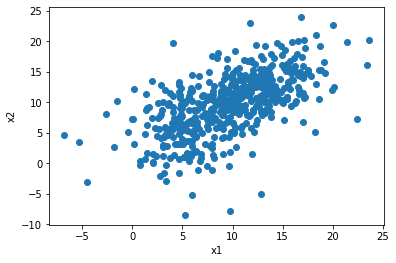

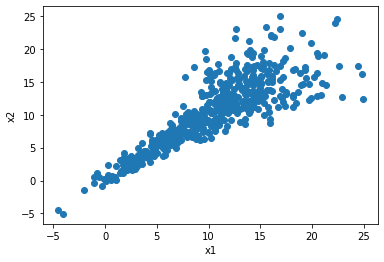

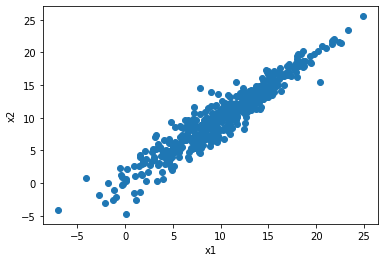

In [ ]:
marginal = [ot.Normal(10,5),ot.Normal(10,5)]
copula_1 = ot.FrankCopula(5)
copula_2 = ot.ClaytonCopula(5)
copula_3 = ot.GumbelCopula(5)
frank_samples = np.asarray(ot.ComposedDistribution(marginal,copula_1).getSample(500))
clayton_samples = np.asarray(ot.ComposedDistribution(marginal,copula_2).getSample(500))
gumbel_samples = np.asarray(ot.ComposedDistribution(marginal,copula_3).getSample(500))
for samples in [frank_samples,clayton_samples,gumbel_samples]:
  fig,ax = plt.subplots()
  ax.scatter(x=samples[:,0],
             y=samples[:,1])
  ax.set(xlabel='x1',ylabel='x2')

[Text(0, 0.5, 'x2'), Text(0.5, 0, 'x1')]

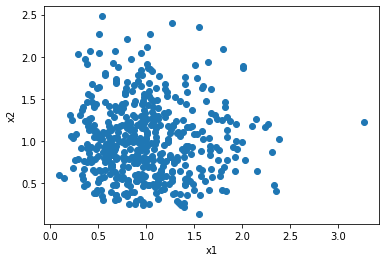

In [ ]:
marginal_1 = [ot.Normal(10,2),ot.Normal(10,2)]
marginal_1 = [ot.Gamma(5,5),ot.Gamma(5,5)]
normal_copula = ot.NormalCopula(ot.CorrelationMatrix(2,(1,0,0,1)))
dist = ot.ComposedDistribution(marginal_1,normal_copula)
normal_samples = np.asarray(dist.getSample(500))
fig,ax = plt.subplots()
ax.scatter(x=normal_samples[:,0],
           y=normal_samples[:,1])
ax.set(xlabel='x1',ylabel='x2')

## 2-d data drawn from a copula with normal marginals

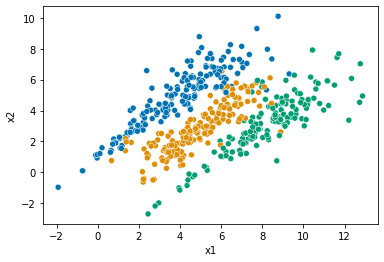

In [ ]:
# Set up three distributions, to sample from
marginals_1 = [ot.Normal(4,2),ot.Normal(5,2)]
marginals_2 = [ot.Normal(5,1.5),ot.Normal(3,1.5)]
marginals_3 = [ot.Normal(8,2),ot.Normal(3,2)]
copula_1 = ot.ClaytonCopula(5)
copula_2 = ot.FrankCopula(12)
copula_3 = ot.ClaytonCopula(5)
dist_1 = ot.ComposedDistribution(marginals_1,copula_1)
dist_2 = ot.ComposedDistribution(marginals_2,copula_2)
dist_3 = ot.ComposedDistribution(marginals_3,copula_3)

# Create list to store random samples
random_samples = []

# Let's do 500 samples
for i in range(500):
  # Randomly draw number between 0 and 1
  discriminant = np.random.random()

  # Draw a sample from a distribution, given the discriminant
  if discriminant <= 1/3:
    current_sample = np.asarray(dist_1.getSample(1))
    current_sample = np.append(current_sample,0)
    random_samples.append(current_sample)
  elif discriminant <= 2/3:
    current_sample = np.asarray(dist_2.getSample(1))
    current_sample = np.append(current_sample,1)
    random_samples.append(current_sample)
  else:
    current_sample = np.asarray(dist_3.getSample(1))
    current_sample = np.append(current_sample,2)
    random_samples.append(current_sample)

samples = np.asarray(random_samples)

# Plot the samples
ax = sns.scatterplot(x=samples[:,0],
                     y=samples[:,1],
                     hue=samples[:,2],
                     palette='colorblind')
ax.set(xlabel='x1',ylabel='x2')
plt.legend([],[], frameon=False)

In [ ]:
full_model = gmm_full_likelihood(data=samples[:,0:2],clusters=3)
performance_metrics(samples[:,2],full_model[1],full_model[0],full_model[2])

Algorithm stopped early after 867 iterations and 800.771969795227 seconds elapsed.


(6359.570530210558, 10645.826966305925, 0.688)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


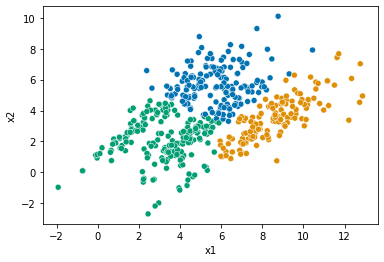

In [ ]:
# Plot the samples
ax = sns.scatterplot(samples[:,0],
                     samples[:,1],
                     hue=full_model[1],
                     palette='colorblind')
ax.set(xlabel='x1',ylabel='x2')
plt.legend([],[], frameon=False)

In [ ]:
copula_model = cmm_pairwise_likelihood(data=samples[:,0:2],
                                       clusters=3,
                                       marginals=['normal','normal'],
                                       copula_types=['clayton','frank','clayton'],
                                       initialisation='random')
performance_metrics(samples[:,2],copula_model[1],copula_model[0],copula_model[2])

Elapsed time = 1.8759636878967285: 1 epochs completed
Elapsed time = 19.98332691192627: 11 epochs completed
Elapsed time = 37.57004237174988: 21 epochs completed
Elapsed time = 54.64787149429321: 31 epochs completed
Elapsed time = 72.09927535057068: 41 epochs completed
Elapsed time = 90.52630281448364: 51 epochs completed
Elapsed time = 110.84033966064453: 61 epochs completed
Elapsed time = 131.44722437858582: 71 epochs completed
Elapsed time = 154.8131034374237: 81 epochs completed
Elapsed time = 174.2256374359131: 91 epochs completed
Elapsed time = 194.08797478675842: 101 epochs completed
Elapsed time = 212.95934796333313: 111 epochs completed
Elapsed time = 232.60424780845642: 121 epochs completed
Elapsed time = 252.89608669281006: 131 epochs completed
Algorithm stopped early after 140 iterations and 268.7470905780792 seconds elapsed.


(5173.452040649354, 9425.991611957345, 0.958)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


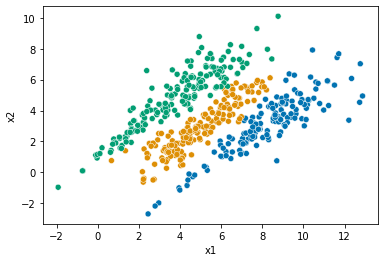

In [ ]:
# Plot the samples
ax = sns.scatterplot(samples[:,0],
                     samples[:,1],
                     hue=copula_model[1],
                     palette='colorblind')
ax.set(xlabel='x1',ylabel='x2')
plt.legend([],[], frameon=False)

## Discrete marginals

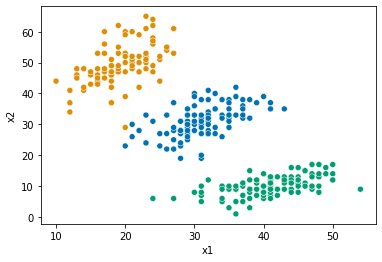

In [ ]:
# Set up three distributions, to sample from
marginals_1 = [ot.Poisson(30),ot.Poisson(30)]
marginals_2 = [ot.Poisson(20),ot.Poisson(50)]
marginals_3 = [ot.Poisson(40),ot.Poisson(10)]
copula_1 = ot.FrankCopula(5)
copula_2 = ot.FrankCopula(5)
copula_3 = ot.FrankCopula(5)
dist_1 = ot.ComposedDistribution(marginals_1,copula_1)
dist_2 = ot.ComposedDistribution(marginals_2,copula_2)
dist_3 = ot.ComposedDistribution(marginals_3,copula_3)

# Create list to store random samples
random_samples = []

# Let's do 300 samples
for i in range(300):
  # Randomly draw number between 0 and 1
  discriminant = np.random.random()

  # Draw a sample from a distribution, given the discriminant
  if discriminant <= 1/3:
    current_sample = np.asarray(dist_1.getSample(1))
    current_sample = np.append(current_sample,0)
    random_samples.append(current_sample)
  elif discriminant <= 2/3:
    current_sample = np.asarray(dist_2.getSample(1))
    current_sample = np.append(current_sample,1)
    random_samples.append(current_sample)
  else:
    current_sample = np.asarray(dist_3.getSample(1))
    current_sample = np.append(current_sample,2)
    random_samples.append(current_sample)

samples = np.asarray(random_samples)

# Plot the samples
ax = sns.scatterplot(x=samples[:,0],
                     y=samples[:,1],
                     hue=samples[:,2],
                     palette='colorblind')
ax.set(xlabel='x1',ylabel='x2')
plt.legend([],[], frameon=False)

In [ ]:
copula_model = cmm_pairwise_likelihood(data=samples[:,0:2],
                                       clusters=3,
                                       marginals=['poisson','poisson'],
                                       copula_types=['frank','frank','frank'])
print(performance_metrics(samples[:,2],copula_model[1],copula_model[0],copula_model[2]))
print(copula_model[3])
print(copula_model[4])
print(copula_model[5])

/usr/local/lib/python3.7/dist-packages/copulas/bivariate/base.py:160: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn("Data does not appear to be uniform.", category=RuntimeWarning)


Elapsed time = 68.21614360809326: 1 epochs completed
Algorithm stopped early after 5 iterations and 263.05972266197205 seconds elapsed.
(4656.123431672262, 6904.319393788575, 0.9966666666666667)
[0.36014452 0.31331529 0.32654018]
[[[40.99105178  0.          0.          0.        ]
  [10.12886103  0.          0.          0.        ]]

 [[19.43982776  0.          0.          0.        ]
  [49.52345058  0.          0.          0.        ]]

 [[31.04052753  0.          0.          0.        ]
  [30.95934962  0.          0.          0.        ]]]
[[[1.         4.30579517]
  [4.30579517 1.        ]]

 [[1.         5.03568638]
  [5.03568638 1.        ]]

 [[1.         4.80093519]
  [4.80093519 1.        ]]]


## Mixed-domain data

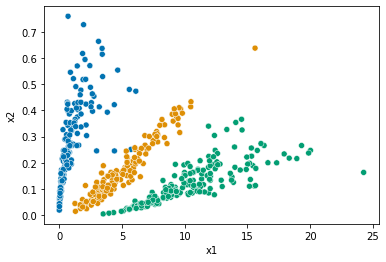

In [ ]:
# Set up three distributions, to sample from
marginals_1 = [ot.Gamma(1,1),ot.Beta(2,5,0,1)]
marginals_2 = [ot.Gamma(5,1),ot.Beta(2,10,0,1)]
marginals_3 = [ot.Gamma(10,1),ot.Beta(2,15,0,1)]
copula_1 = ot.ClaytonCopula(5)
copula_2 = ot.GumbelCopula(5)
copula_3 = ot.ClaytonCopula(5)
dist_1 = ot.ComposedDistribution(marginals_1,copula_1)
dist_2 = ot.ComposedDistribution(marginals_2,copula_2)
dist_3 = ot.ComposedDistribution(marginals_3,copula_3)

# Create list to store random samples
random_samples = []

# Let's do 500 samples
for i in range(500):
  # Randomly draw number between 0 and 1
  discriminant = np.random.random()

  # Draw a sample from a distribution, given the discriminant
  if discriminant <= 1/3:
    current_sample = np.asarray(dist_1.getSample(1))
    current_sample = np.append(current_sample,0)
    random_samples.append(current_sample)
  elif discriminant <= 2/3:
    current_sample = np.asarray(dist_2.getSample(1))
    current_sample = np.append(current_sample,1)
    random_samples.append(current_sample)
  else:
    current_sample = np.asarray(dist_3.getSample(1))
    current_sample = np.append(current_sample,2)
    random_samples.append(current_sample)

samples = np.asarray(random_samples)

# Plot the samples
ax = sns.scatterplot(x=samples[:,0],
                     y=samples[:,1],
                     hue=samples[:,2],
                     palette='colorblind')
ax.set(xlabel='x1',ylabel='x2')
plt.legend([],[], frameon=False)

In [ ]:
copula_model = cmm_pairwise_likelihood(data=samples[:,0:2],
                                       clusters=3,
                                       marginals=['gamma','beta'],
                                       copula_types=['frank','frank','frank'],
                                       initialisation='random')
print(performance_metrics(samples[:,2],copula_model[1],copula_model[0],copula_model[2]))
print(copula_model[3])
print(copula_model[4])
print(copula_model[5])

Elapsed time = 316.4275748729706: 41 epochs completed
Elapsed time = 405.23707032203674: 51 epochs completed
Elapsed time = 493.6787405014038: 61 epochs completed
Elapsed time = 588.1911859512329: 71 epochs completed
Elapsed time = 667.0522565841675: 81 epochs completed
Elapsed time = 764.7301685810089: 91 epochs completed
Elapsed time = 866.878965139389: 101 epochs completed
Elapsed time = 967.5069007873535: 111 epochs completed
Algorithm stopped early after 114 iterations and 996.9792439937592 seconds elapsed.
(2171.144793271643, 6423.684364579634, 0.994)
[0.30859747 0.36386848 0.32753405]
[[[ 4.40731379  0.81242261  7.39252731  0.        ]
  [ 1.94990033  8.46461805  0.          0.        ]]

 [[ 8.40563306  0.87283399  6.27067095  0.        ]
  [ 1.82826754 15.34054428  0.          0.        ]]

 [[ 0.7211822   0.92410833  5.14814675  0.        ]
  [ 1.58505986  5.08143282  0.          0.        ]]]
[[[ 1.         19.03717239]
  [19.03717239  1.        ]]

 [[ 1.         12.7958968

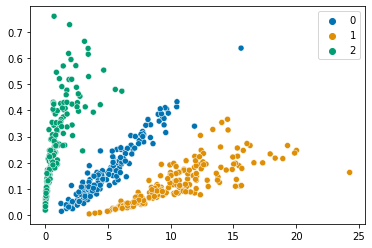

In [ ]:
ax = sns.scatterplot(x=samples[:,0],
                     y=samples[:,1],
                     hue=copula_model[1],
                     palette='colorblind')

## Mixed-mode data

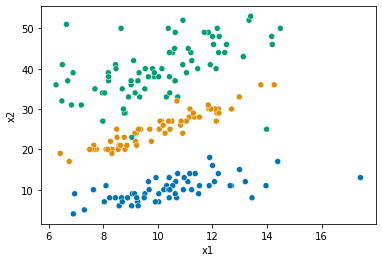

In [ ]:
# Set up three distributions, to sample from
marginals_1 = [ot.Normal(10,2),ot.Poisson(10)]
marginals_2 = [ot.Normal(10,2),ot.Poisson(25)]
marginals_3 = [ot.Normal(10,2),ot.Poisson(40)]
copula_1 = ot.FrankCopula(5)
copula_2 = ot.GumbelCopula(5)
copula_3 = ot.FrankCopula(5)
dist_1 = ot.ComposedDistribution(marginals_1,copula_1)
dist_2 = ot.ComposedDistribution(marginals_2,copula_2)
dist_3 = ot.ComposedDistribution(marginals_3,copula_3)

# Create list to store random samples
random_samples = []

# Let's do 200 samples
for i in range(200):
  # Randomly draw number between 0 and 1
  discriminant = np.random.random()

  # Draw a sample from a distribution, given the discriminant
  if discriminant <= 1/3:
    current_sample = np.asarray(dist_1.getSample(1))
    current_sample = np.append(current_sample,0)
    random_samples.append(current_sample)
  elif discriminant <= 2/3:
    current_sample = np.asarray(dist_2.getSample(1))
    current_sample = np.append(current_sample,1)
    random_samples.append(current_sample)
  else:
    current_sample = np.asarray(dist_3.getSample(1))
    current_sample = np.append(current_sample,2)
    random_samples.append(current_sample)

samples = np.asarray(random_samples)

# Plot the samples
ax = sns.scatterplot(x=samples[:,0],
                     y=samples[:,1],
                     hue=samples[:,2],
                     palette='colorblind')
ax.set(xlabel='x1',ylabel='x2')
plt.legend([],[], frameon=False)

In [ ]:
copula_model = cmm_pairwise_likelihood(data=samples[:,0:2],
                                       clusters=3,
                                       marginals=['normal','poisson'],
                                       copula_types=['frank','gumbel','frank'],
                                       initialisation='random')
print(performance_metrics(samples[:,2],copula_model[1],copula_model[0],copula_model[2]))
print(copula_model[3])
print(copula_model[4])
print(copula_model[5])

/usr/local/lib/python3.7/dist-packages/copulas/bivariate/base.py:160: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn("Data does not appear to be uniform.", category=RuntimeWarning)


Elapsed time = 4.9648826122283936: 1 epochs completed
Algorithm stopped early after 4 iterations and 19.1180682182312 seconds elapsed.
(2821.3438269044173, 4167.057312456016, 0.955)
[0.29325662 0.31052609 0.39621729]
[[[ 9.68822167  1.91861077  0.          0.        ]
  [10.17878363  0.          0.          0.        ]]

 [[ 9.11142741  1.553104    0.          0.        ]
  [22.20479266  0.          0.          0.        ]]

 [[ 9.84748037  1.99249845  0.          0.        ]
  [40.08546132  0.          0.          0.        ]]]
[[[1.         6.30917525]
  [6.30917525 1.        ]]

 [[1.         1.06081512]
  [1.06081512 1.        ]]

 [[1.         2.89856157]
  [2.89856157 1.        ]]]


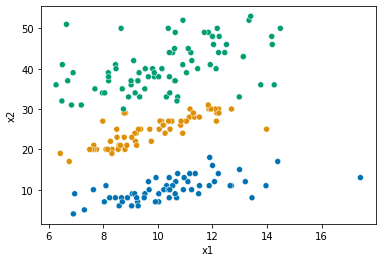

In [ ]:
ax = sns.scatterplot(x=samples[:,0],
                     y=samples[:,1],
                     hue=copula_model[1],
                     palette='colorblind')
ax.set(xlabel='x1',ylabel='x2')
plt.legend([],[], frameon=False)

# Real data-sets

## Seeds data

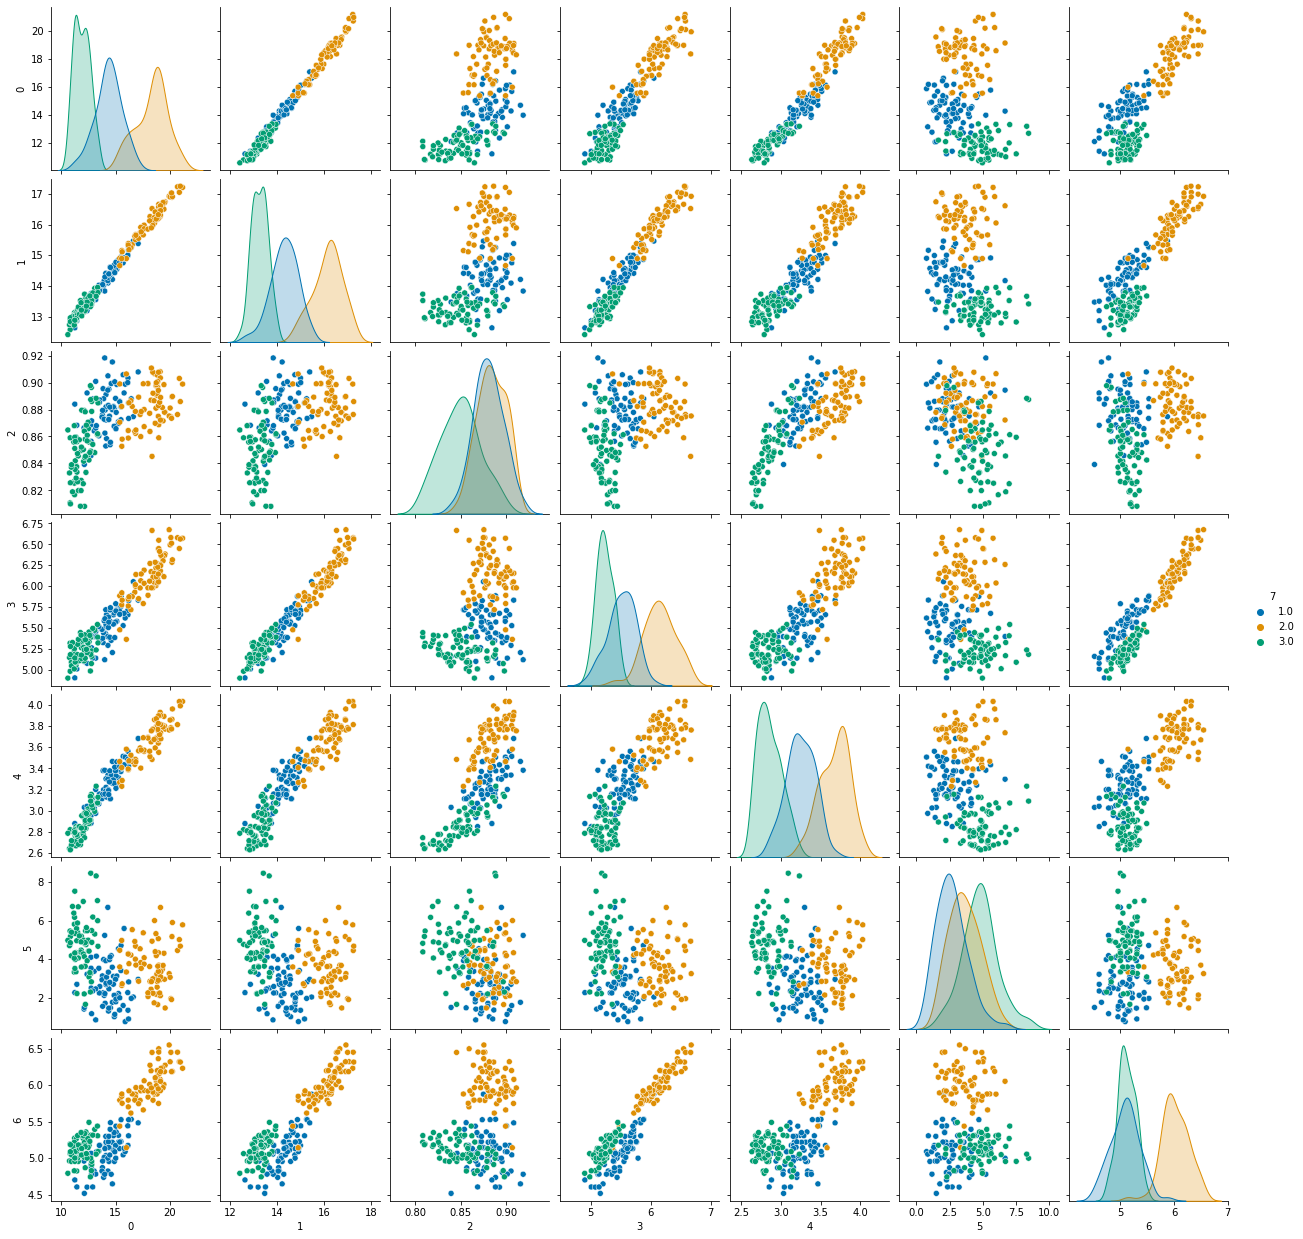

In [ ]:
# Import the data-set
seeds_data = np.genfromtxt('/content/gdrive/MyDrive/diss_data/seeds_data.csv',delimiter=',')

# Some gentle EDA
sns.pairplot(pd.DataFrame(seeds_data),
             hue=7,
             palette='colorblind')
plt.savefig('/content/gdrive/MyDrive/diss_data/seeds_pairplot.png')

In [ ]:
for i in range(10):
  # Fit the model
  copula_model = cmm_pairwise_likelihood(data=seeds_data[:,0:7],
                                         clusters=3,
                                         marginals=['normal','normal','beta','normal','normal','normal','normal'],
                                         copula_types=['normal','normal','normal'],
                                         tol=1)

  # Evaluate performance
  performance = performance_metrics(seeds_data[:,7],copula_model[1],copula_model[0],copula_model[2])

  # Return performance
  print(performance[2]) 

IndexError: ignored

In [ ]:
# Reduce the data
pca = sklearn.decomposition.PCA(0.95)
reduced_seeds_data = pca.fit_transform(seeds_data)

# Fit a model
copula_model = cmm_pairwise_likelihood(data=reduced_seeds_data,
                                       clusters=3,
                                       marginals=['normal','normal'],
                                       copula_types=['frank','normal','frank'],
                                       initialisation='random')

performance_metrics(seeds_data[:,7],copula_model[1],copula_model[0],copula_model[2])

-709.3879211556346
-709.3834060957271
-709.3783684011976
-709.3734654072682
-709.3689542974341
Elapsed time = 132.8055465221405: 131 epochs completed
-709.3641473761512
-709.3588912377389
-709.3535764433055
-709.348835613887
-709.3438625294343
-709.3388571390514
-709.3339449611833
-709.3292417300004
-709.3242667318569
-709.31962155399
Elapsed time = 140.42941117286682: 141 epochs completed
-709.3146223207467
-709.3097251364792
-709.3051685090496
-709.3008493785206
-709.2960351423818
-709.2915249034739
-709.2874061477792
-709.282755683708
-709.2782321042012
-709.2734325253423
Elapsed time = 147.9738895893097: 151 epochs completed
-709.2689853739541
-709.2649783045965
-709.2604740715766
-709.2559330224432
-709.2516235292636
-709.2469537763578
-709.2429866531784
-709.2390516158323
-709.2354793328698
-709.2305420428435
Elapsed time = 155.5295488834381: 161 epochs completed
-709.2266667024969
-709.2224644727577
-709.2184427143216
-709.2147110083638
-709.2108371022763
-709.2069761260705
-709

(2276.0330072432175, 3711.9421379210116, 0.3238095238095238)

## Learning data

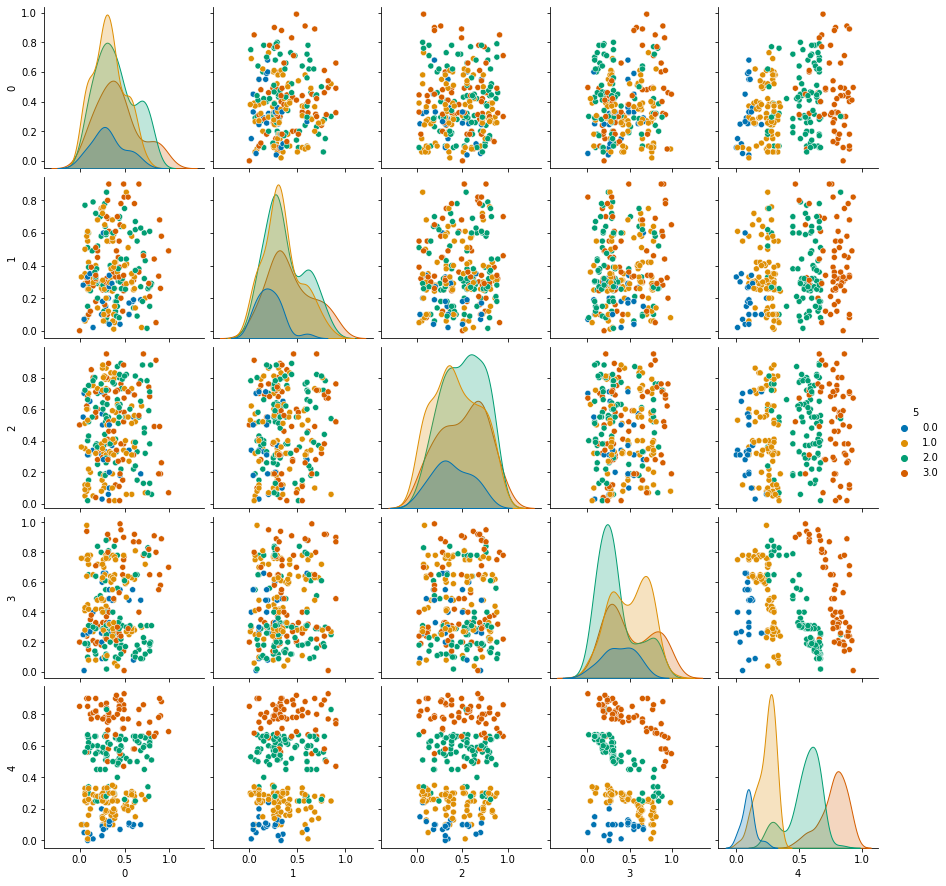

In [ ]:
# Import the data-set
learning_data = np.genfromtxt('/content/gdrive/MyDrive/diss_data/learning_data.csv',delimiter=',')

# Some gentle EDA
sns.pairplot(pd.DataFrame(learning_data),
             hue=5,
             palette='colorblind')

In [ ]:
for i in range(10):
  # Fit the model
  copula_model = cmm_pairwise_likelihood(data=learning_data[:,0:5],
                                         clusters=4,
                                         marginals=['beta','beta','beta','beta','beta'],
                                         copula_types=['normal','normal','normal','normal','normal'],
                                         tol=1)

  # Evaluate performance
  performance = performance_metrics(learning_data[:,5],copula_model[1],copula_model[0],copula_model[2])

  # Return performance
  print(performance[2])